In [1]:
import sys#TylerK: Add sys to get cmdline_helper from NRPy top directory; remove this line and next when debugged
sys.path.append('../')

import cmdline_helper as cmd     # NRPy+: Multi-platform Python command-line interface

# Create C code output directory:
Ccodesdir = "EOB2PN_Playground_Pycodes"

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spint
import Hamiltonian.EOB2PN_Hreal_on_bottom as hr
import Derivatives.EOB2PN_hamiltonian_first_derivatives as dh



# Tutorial - Right-Hand-Side's for Hamilton's Equation of Motion for SEOBNR Models

In this notebook, we will implement the right hand side functions for the Hamilton's EOMs so that we can integrate them to get the trajectory. Since we are using scipy's ODE integration functionality, we will be writing these as wrappers that will ultimately be passed into the scipy functions.

To begin, we will recap the ODEs that form the Hamilton's EOMs and document the individual terms. We then create the wrapper function that will pass the phase space variables and parameters to the derivative functions generated before.

## Step : Hamilton's EOMs for SEOBNR implementations

The Hamilton's EOMs for a general SEOBNR implementation is given in https://arxiv.org/pdf/gr-qc/9811091.pdf as a set of derivatives for the positions, and momenta as well as a reactive term.
We begin by stating the derivatives as

$$
\frac{dq^i}{dt} = \frac{\partial \mathcal{H}_\rm{real}(q,p)}{\partial p_i} + \frac{\partial \mathcal{H}^{\rm reac}(q,p,t)}{\partial p_i}\\
\frac{dp^i}{dt} = -\frac{\partial \mathcal{H}_\rm{real}(q,p)}{\partial q_i} - \frac{\partial \mathcal{H}^{\rm reac}(q,p,t)}{\partial q_i}
$$

where $p$ represent the momenta.

Finally, the reactive part of the derivatives are given as

$$
\mathcal{H}^{\rm reac} = -h^{\rm reac}_{ij}(t)\left\{ \frac{1}{2}p^ip^j - \frac{1}{2}\frac{q^iq^j}{q^3} \right\}
$$

with the reactive flux term given by:

$$
h^{\rm reac}_{ij}(t) = -\frac{4\eta u^2}{5}\left( -4(p^in^j + p^jn^i) + 6({\bf n}\cdot{\bf p})n^in^j + \frac{2}{3}({\bf n}\cdot{\bf p})\delta^{ij}  \right) 
$$

Using properties of the normal vectors and the symmetricity of the flux tensor we have:

$$
\frac{\partial \mathcal{H}^{\rm reac}}{\partial q^i} = \frac{u^2}{2}(2h^{\rm reac}_{ij}n^j - 3h^{\rm reac}_{jk}n^jn^kn^i)
$$

on the other hand we also have

$$
\frac{\partial \mathcal{H}^{\rm reac}}{\partial p^i} = -h^{\rm reac}_{ij}p^{j}
$$

In [2]:
def EOB2PN_RHS(t,var,m1,m2):
    
    ## Unwrap all arguments
    eta = m1*m2/(m1+m2)/(m1+m2)
    qvec = np.array([var[0], var[1], var[2]])
    pvec = np.array([var[3], var[4], var[5]])
    
    q = np.linalg.norm(qvec)
    u = 1/q
    u2 = u*u
    nvec = qvec*u
    ndotp = np.dot(nvec,pvec)
    
    kron_delta = lambda x,y: 1 if x== y else 0
    
    dHreal = dh.ham_first_derivs(m1,m2,var[0],var[1],var[2],var[3],var[4],var[5])
    dHdX = np.array([dHreal[0],dHreal[1],dHreal[2]])
    dHdP = np.array([dHreal[3],dHreal[4],dHreal[5]])
    
    flux_term = np.zeros([3,3])
    
    for i in range(3):
        for j in range(3):
            f1 = -4*(pvec[i]*nvec[j] + pvec[j]*nvec[i])
            f2 = 6*ndotp*nvec[i]*nvec[j]
            f3 = 2*ndotp*kron_delta(i,j)/3
            flux_term[i,j] = -(4/5)*eta*u2*( f1 + f2 + f3 )
    
    fluxdotn = np.zeros(3) ## store h_ij*n^j here
    fluxdotp = np.zeros(3) ## store h_ij*p^j here
    fluxdotndotn = 0 ## store h_ij*n^i*n^j = (h_ij*n^j)*n^i here
    
    for i in range(3):
        for j in range(3):
            fluxdotn[i] += flux_term[i,j]*nvec[j]
            fluxdotp[i] += flux_term[i,j]*pvec[j]
    
    for i in range(3):
        fluxdotndotn += fluxdotn[i]*nvec[i]
    
    dHreac_dX = u2*0.5*(2*fluxdotn - 3*fluxdotndotn*nvec)
    dHreac_dP = -fluxdotp
    
    dX = dHdP + dHreac_dP
    dP = -dHdX - dHreac_dX
                
    return np.array([dX[0],dX[1],dX[2],dP[0],dP[1],dP[2]])


## Testing the RHS with the Initial Conditions

Here, we will plug into the RHS routine the initial conditions obtained from LALSuite in order to check if the function yields the correct right hand sides

[28.76727414  0.19941807]


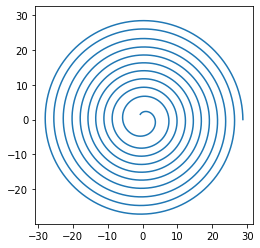

In [3]:
## simply ported final initial conditions from our lal solver

m1 = 1
m2 = 1
f = 200.
Msol = 4.925491025543575903411922162094833998e-6
omega = Msol*(m1+m2)*np.pi*f
v = np.cbrt(omega)
vsq = v*v


params = (m1,m2)

from scipy.optimize import root

root_guess = [np.divide(1,v*v), v*2]
# This is the same initial guess given to GSL in LALSuite, but you won't know it unless you're
# careful about their scale factors (which are done and undone and done and undone...)

# Define the function of which we want to find the roots
def root_func(F):
    eta = m1*m2/(m1+m2)/(m1+m2)
    dH = dh.ham_first_derivs(m1,m2,F[0],0,0,0,F[1],0)
    dHdx = dH[0]
    dHdp2 = dH[4]
    return [dHdx+(-dHdp2*F[1])/F[0], dHdp2/F[0]-omega]

# Find the roots of root_func
soln = root(root_func, root_guess, args=(), method='hybr', jac=None, tol=None, callback=None)
if not(soln.success):
    print("The root finder failed with error message: %s" % soln.message)
    sys.exit(1)

print(soln.x)
init_conditions = np.array([soln.x[0],0,0,0,soln.x[1],0])
## set px according to note above eq 4.11

max_time = 4975

result = spint.solve_ivp(EOB2PN_RHS,(0,max_time),init_conditions,method = 'RK45',dense_output=True,args = params)

dt = .1
time_series = np.arange(0.,max_time,dt)

sparse_array = result.y
dense_sol = result.sol.__call__(time_series)

plot_array = np.array([dense_sol[:,i] for i in range(len(time_series))])
plt.plot(plot_array[:,0],plot_array[:,1])
plt.axis('square')
plt.savefig('EOB2PNfirstrun.png')
#print(sparse_array)


0.0017330791229746012


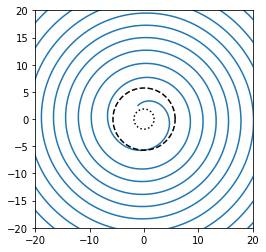

In [4]:
def convertunprimedtoprime(m1,m2,var):
    q1 , q2 , q3 = var[0] , var[1] , var[2]
    p1 , p2 , p3 = var[3] , var[4] , var[5]
    M = m1 + m2
    mu=m1*m2/M
    eta=mu/M
    q=np.sqrt(q1*q1+q2*q2+q3*q3)
    u=1/q
    psq=p1*p1+p2*p2+p3*p3
    n3=q3/q
    n2 = q2/q
    n1 = q1/q
    ndotp=n1*p1+n2*p2+n3*p3
    qprime2PN3=(1+0.125*eta)*eta*ndotp*ndotp*n3+0.25*(5-0.5*eta)*eta*psq*n3+1.5*(1-0.5*eta)*eta*ndotp*p3+0.25*(1-7*eta+eta*eta)*u*n3+0.125*(1-eta)*eta*q*psq*psq*n3+0.5*(1+eta)*eta*q*ndotp*psq*p3
    qprime2PN2 = (1 + 0.125*eta)*eta*ndotp*ndotp*n2 + 0.25*(5 - 0.5*eta)*eta*psq*n2 + 1.5*(1 - 0.5*eta)*eta*ndotp*p2  + 0.25*(1 - 7*eta + eta*eta)*u*n2 + 0.125*(1 - eta)*eta*q*psq*psq*n2 + 0.5*(1 + eta)*eta*q*ndotp*psq*p2
    qprime2PN1 = (1 + 0.125*eta)*eta*ndotp*ndotp*n1 + 0.25*(5 - 0.5*eta)*eta*psq*n1 + 1.5*(1 - 0.5*eta)*eta*ndotp*p1  + 0.25*(1 - 7*eta + eta*eta)*u*n1 + 0.125*(1 - eta)*eta*q*psq*psq*n1 + 0.5*(1 + eta)*eta*q*ndotp*psq*p1
    qprime1PN3=(1+0.5*eta)*n3-0.5*eta*psq*q3-eta*q*ndotp*p3
    qprime1PN2 = (1 + 0.5*eta)*n2 - 0.5*eta*psq*q2 - eta*q*ndotp*p2
    qprime1PN1 = (1 + 0.5*eta)*n1 - 0.5*eta*psq*q1 - eta*q*ndotp*p1
    qprime3=q3+qprime1PN3+qprime2PN3
    qprime2 = q2 + qprime1PN2 + qprime2PN2
    qprime1 = q1 + qprime1PN1 + qprime2PN1
    pprime2PN3=0.125*eta*psq*psq*(-1+3*eta)*p3+0.25*(3+11*eta)*u*u*p3-0.75*(3+0.5*eta)*ndotp*u*u*n3+0.25*(-2-18*eta+eta*eta)*u*u*n3+0.125*(10-eta)*eta*u*ndotp*psq*n3-0.125*(16+5*eta)*eta*u*ndotp*ndotp*p3+0.375*eta*u*ndotp*ndotp*ndotp*n3
    pprime2PN2 = 0.125*eta*psq*psq*(-1 + 3*eta)*p2 + 0.25*(3 + 11*eta)*u*u*p2 - 0.75*(3 + 0.5*eta)*ndotp*u*u*n2 + 0.25*(-2 -18*eta+ eta*eta)*u*u*n2 + 0.125*(10 - eta)*eta*u*ndotp*psq*n2 - 0.125*(16+5*eta)*eta*u*ndotp*ndotp*p2 + 0.375*eta*u*ndotp*ndotp*ndotp*n2
    pprime2PN1 = 0.125*eta*psq*psq*(-1 + 3*eta)*p1 + 0.25*(3 + 11*eta)*u*u*p1 - 0.75*(3 + 0.5*eta)*ndotp*u*u*n1 + 0.25*(-2 -18*eta+ eta*eta)*u*u*n1 + 0.125*(10 - eta)*eta*u*ndotp*psq*n1 - 0.125*(16+5*eta)*eta*u*ndotp*ndotp*p1 + 0.375*eta*u*ndotp*ndotp*ndotp*n1
    pprime1PN3=-(1+0.5*eta)*u*p3+0.5*eta*psq*p3+(1+0.5*eta)*u*ndotp*n3
    pprime1PN2 = -(1 + 0.5*eta)*u*p2 + 0.5*eta*psq*p2 + (1 + 0.5*eta)*u*ndotp*n2
    pprime1PN1 = -(1 + 0.5*eta)*u*p1 + 0.5*eta*psq*p1 + (1 + 0.5*eta)*u*ndotp*n1
    pprime3=p3+pprime1PN3+pprime2PN3
    pprime2 = p2 + pprime1PN2 + pprime2PN2
    pprime1 = p1 + pprime1PN1 + pprime2PN1
    return np.array([qprime1,qprime2,qprime3,pprime1,pprime2,pprime3])

var_prime = []
for i in range(len(plot_array)):
    var_prime.append(convertunprimedtoprime(m1,m2,plot_array[i]))
    
var_prime = np.array(var_prime)

r_isco_eqmass = 6/(1.049)
print(r_isco_eqmass - 5.718)
r_horizon_eqmass = 2*0.9277
phi = np.arange(0,2*np.pi,0.01)
circle = np.array([np.array([np.cos(phi[i]),np.sin(phi[i])]) for i in range(len(phi))])

isco = r_isco_eqmass*circle
horizon = r_horizon_eqmass*circle

plt.plot(var_prime[:,0],var_prime[:,1])
plt.plot(isco[:,0],isco[:,1],color = 'black', linestyle = 'dashed')
plt.plot(horizon[:,0], horizon[:,1],color = 'black', linestyle = 'dotted')
plt.axis('square')
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.savefig('EOB2PNprimed.png')
plt.show()

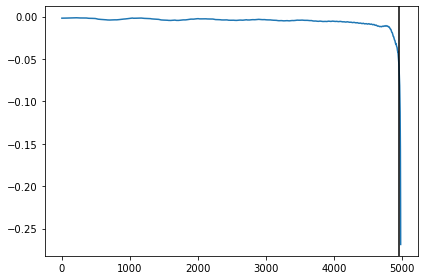

In [5]:
radii2 = np.array([var_prime[i,0]**2 + var_prime[i,1]**2 for i in range(len(var_prime))])
radii = np.sqrt(radii2)

dradii = np.gradient(radii,time_series)
isco_time = np.argmin(np.abs(radii - r_isco_eqmass))

plt.plot(time_series,dradii)
plt.axvline(time_series[isco_time],color = 'black')
plt.tight_layout()

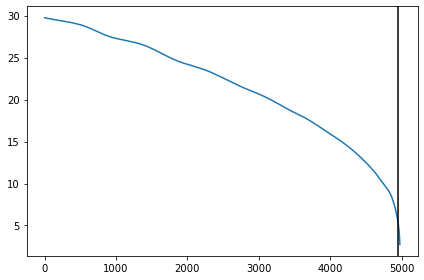

In [6]:
plt.plot(time_series,radii)
plt.axvline(time_series[isco_time],color = 'black')
plt.tight_layout()

In [7]:
r = radii
q = var_prime[:,:3]
p = var_prime[:,3:]
nvec = np.array( [ var_prime[i,:3]/radii[i] for i in range(len(var_prime)) ])
phvec = np.array([np.cross(np.array([0,0,1]),nvec[i]) for i in range(len(nvec))]) 

pr = np.array([np.dot(nvec[i],p[i]) for i in range(len(nvec))])
pphi = np.array([np.dot(np.array([0,0,1]),np.cross(q[i],p[i])) for i in range(len(q))])

A = 1 - 2/r + 2*0.25/r/r/r
B = (1 - 6*0.25/r/r)/A

pr2_B = pr*pr/B
pphi2_r2 = pphi*pphi/r/r



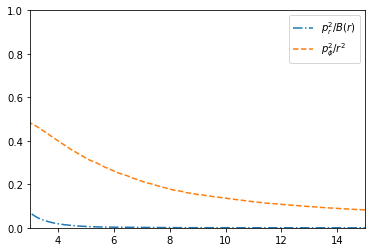

In [8]:
plt.plot(r,pr2_B,linestyle = 'dashdot',label = r'$p_r^2/B(r)$')
plt.plot(r,pphi2_r2,linestyle = 'dashed',label = r'$p_\phi^2/r^2$')
plt.xlim(3,15)
plt.ylim(0,1)
plt.legend()
plt.savefig('BD1QCcompare.png')

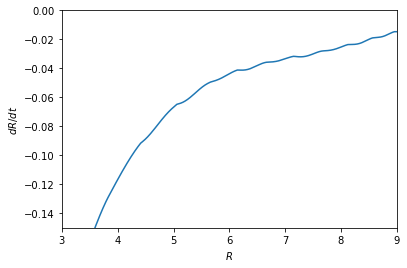

In [9]:
plt.plot(radii,dradii)
plt.xlim(3,9)
plt.ylim(-0.15,0)
plt.ylabel(r'$dR/dt$')
plt.xlabel(r'$R$')
plt.savefig('BD1drdtbyr.png')

## Method 2: The second method from DB1999

Here we illustrate a second method to incorporate radiation reaction where they neglect the radiation reaction force on all derivatives except the azimuthal.



In [10]:
def EOB2PN2_RHS(t,var,m1,m2):
    r, phi = var[0] , var[1]
    pr , pphi = var[2] , var[3]
    u = 1/r
    eta = m1*m2/(m1+m2)/(m1+m2)
    etainv = 1/eta
    A = 1 - 2*u + 2*eta*u*u*u
    Aprime = 2*u*u - 6*eta*u*u*u*u
    Ainv = 1/A
    
    B = (1 - 6*eta*u*u)*Ainv
    Bprime = (12*eta*u*u*u - B*Aprime)*Ainv
    Binv = 1/B
    
    pdotp = pr*pr*Binv + pphi*pphi*u*u + 1
    pdotp_r = -pr*pr*Bprime*Binv*Binv - 2*pphi*pphi*u*u*u
    Heff2 = A*(pdotp)
    
    Heff = np.sqrt(Heff2)
    Heffinv = 1/Heff
    sqrtterm = np.sqrt(1 + 2*eta*(Heff - 1))
    sqrtterminv = 1/sqrtterm
    Hreal = etainv*sqrtterm
    
    dHdr = 0.5 * (Aprime*pdotp + A*pdotp_r) * sqrtterminv * Heffinv
    
    dHdpr = pr * A * Binv * Heffinv * sqrtterminv
    
    dHdpphi = pphi *A * u * u * Heffinv * sqrtterminv
    
    vw = np.cbrt(dHdpphi)
    vw7 = vw*vw*vw*vw*vw*vw*vw
    
    vdis = np.sqrt(1/3)*np.sqrt(1 + eta/3)/np.sqrt(1 - 35*eta/36)
    
    onemvwvdisinv = 1/(1 - vw/vdis)
    
    F0 = 1
    F1 = 0
    F2 = -1247/336 - 35*eta/12
    F3 = 4*np.pi
    F4 = -44711/9072 + 9271*eta/504 + 65*eta*eta/18
    F5 = -(8191/672 + 535*eta/24)*np.pi
    
    f1 = F1 - F0/vdis
    f2 = F2 - F1/vdis 
    f3 = F3 - F2/vdis
    f4 = F4 - F3/vdis
    f5 = F5 - F4/vdis
    
    c1 = -f1
    
    c2 = f1 - f2/f1
    
    c3 = (f1*f3 - f2*f2)/(f1*(f1*f1 - f2))
    
    c4 = -f1 * ( f2*f2*f2 + f3*f3 + f1*f1*f4 - f2*(2*f1*f3 + f4) ) / ( (f1*f1 - f2)*(f1*f3 - f2*f2) )
    
    c5 = -(f1*f1 - f2)*(-f3*f3*f3 + 2*f2*f3*f4 - f1*f4*f4 - f2*f2*f5 + f1*f3*f5)/((f1*f3 - f2*f2)*(f2*f2*f2 + f3*f3 + f1*f1*f4 - f2*(2*f1*f3 + f4)))
    
    fdis =  1/(1 + c1*v/(1 + c2*vw/(1 + c3*vw/(1 + c4*vw/(1 + c5*vw)))))
    
    Fphi = -32*0.2*eta*vw7*fdis*onemvwvdisinv
    
    return np.array([dHdpr,dHdpphi,-dHdr,Fphi])
    


<ipython-input-10-4b79cb4f6cb4>:19: RuntimeWarning: invalid value encountered in sqrt
  Heff = np.sqrt(Heff2)


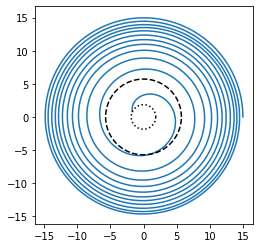

In [11]:
r = 15
eta = m1*m2/(m1+m2)/(m1+m2)
a = r*r - 3*eta
b = r*r*r - 3*r*r + 5*eta
aprime = 2*r
bprime = 3*r*r - 6*r
jadiab = r*np.sqrt(a/b)
djdr = jadiab/r + 0.5*r*(aprime/a - bprime/b)
Fphi = EOB2PN2_RHS(0,np.array([r,0,0,jadiab]),m1,m2)[-1]
vr = Fphi/djdr

def root_func_for_pr(F):
    dH = EOB2PN2_RHS(0,np.array([r,0,F[0],jadiab]),m1,m2)
    dHdpr = dH[2]
    return vr - dHdpr

pr_guess = vr
pr_soln = root(root_func_for_pr, pr_guess, args=(), method='hybr', jac=None, tol=None, callback=None)
#if not(pr_soln.success):
#    print("The root finder failed with error message: %s" % soln.message)
#    sys.exit(1)

#print(pr_soln.x)
pr = pr_soln.x[0]
init_conds = np.array([r,0,pr,jadiab])
max_time_2 = 2819.

result_2 = spint.solve_ivp(EOB2PN2_RHS,(0,max_time_2),init_conds,method = 'RK45',dense_output=True,args = params)

dt_2 = 1
time_series_2 = np.arange(0.,max_time_2,dt_2)

sparse_array_2 = result_2.y
dense_sol_2 = result_2.sol.__call__(time_series_2)

plot_array_2 = np.array([dense_sol_2[0,i]*np.array([np.cos(dense_sol_2[1,i]),np.sin(dense_sol_2[1,i])]) for i in range(len(dense_sol_2[0]))])
plt.plot(plot_array_2[:,0],plot_array_2[:,1])
plt.plot(isco[:,0],isco[:,1],color = 'black', linestyle = 'dashed')
plt.plot(horizon[:,0], horizon[:,1],color = 'black', linestyle = 'dotted')

plt.axis('square')
plt.savefig('EOB2PN2firstrun.png')


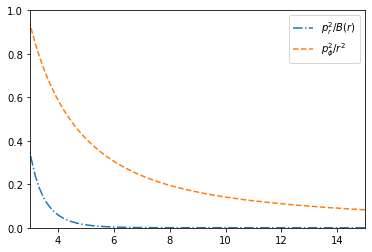

In [12]:
R = dense_sol_2[0,:]
U = 1/R
A = 1 - 2*U + 2*eta*U*U*U
B = (1 - 6*eta*U*U)/A
PR = dense_sol_2[2,:]
PPhi = dense_sol_2[-1,:]

pr2_B = PR*PR/B
pphi2_r2 = PPhi*PPhi/R/R

plt.plot(R,pr2_B,linestyle = 'dashdot',label = r'$p_r^2/B(r)$')
plt.plot(R,pphi2_r2,linestyle = 'dashed',label = r'$p_\phi^2/r^2$')
plt.xlim(3,15)
plt.ylim(0,1)
plt.legend()
plt.savefig('BD2QCcompare.png')

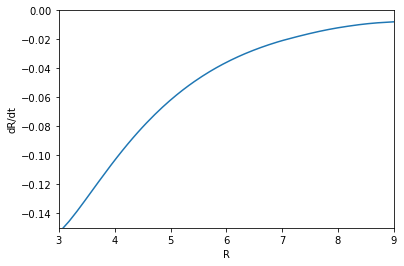

In [13]:
dR = np.gradient(R,time_series_2)

plt.plot(R,dR)
plt.xlim(3,9)
plt.ylim(-0.15,0)
plt.xlabel('R')
plt.ylabel('dR/dt')
plt.savefig('BD2drdtbyr.png')